# Cluster Tumor Supressors and Oncogenes

In [28]:
import pandas as pd
import os, sys, pickle
import gcnIO
import interpretation_avg
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

%matplotlib inline

In [2]:
# parameters
clean = False
lrp_rule = 'saliency'

In [3]:
model_dir = '../data/GCN/training/2018_08_16_17_46_11/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID', inplace=True)

Hyper-Parameters read from ../data/GCN/training/2018_08_16_17_46_11/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomics_qnorm_methpromonly1000bp_ncglabels.h5
{'lr': 0.001, 'support': 2, 'loss_mul': 30.0, 'decay': 0.0005, 'data': '../data/pancancer/iref_multiomics_qnorm_methpromonly1000bp_ncglabels.h5', 'hidden_dims': [50, 40, 30, 20, 10], 'dropout': 0.4, 'cv_runs': 10, 'epochs': 7000}


In [4]:
cancer_gene_list = pd.read_csv('../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0)
print ("Got {} cancer genes".format(cancer_gene_list.shape[0]))
cancer_gene_list.columns = [i.strip('*') for i in cancer_gene_list.columns]
cancer_genes = cancer_gene_list[cancer_gene_list['Gene Symbol'].isin(nodes.Name)]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} oncogenes and {} tumour suppressors".format(oncogenes.shape[0], suppressors.shape[0]))

Got 125 cancer genes
Got 52 oncogenes and 71 tumour suppressors


## Compute LRP for genes of interest

In [5]:
pkl_save_path = os.path.join(model_dir, 'onco_sup_{}.pkl'.format(lrp_rule))
if clean or not os.path.exists(pkl_save_path):
    lrp_supressors = interpretation_avg.interpretation_avg(model_dir=model_dir,
                                                          genes=suppressors['Gene Symbol'],
                                                          out_dir=None)
    lrp_oncogenes = interpretation_avg.interpretation_avg(model_dir=model_dir,
                                                          genes=oncogenes['Gene Symbol'],
                                                          out_dir=None)
    with open(pkl_save_path, 'wb') as f:
        pickle.dump(((suppressors['Gene Symbol'], lrp_supressors), (oncogenes['Gene Symbol'], lrp_oncogenes)), f)
else:
    with open(pkl_save_path, 'rb') as f:
        sup, onc = pickle.load(f)
    sup_names, lrp_supressors = sup
    onc_names, lrp_oncogenes = onc

## Get the LRP features to DF

In [6]:
def get_lrp_feature_col(node_names, lrp_list, gene_name):
    idx = np.where(node_names[:, 1] == gene_name)[0]
    return lrp_list.mean(axis=0)[idx].reshape(-1)
    #return lrp_list.mean(axis=0).reshape(-1)
features_sup = []
for gene in range(suppressors.shape[0]):
    lrp_i = get_lrp_feature_col(node_names=node_names,
                                lrp_list=lrp_supressors[gene],
                                gene_name=suppressors['Gene Symbol'].iloc[gene]
                               )
    features_sup.append(lrp_i)

features_onc = []
for gene in range(oncogenes.shape[0]):
    lrp_i = get_lrp_feature_col(node_names=node_names,
                                lrp_list=lrp_oncogenes[gene],
                                gene_name=oncogenes['Gene Symbol'].iloc[gene]
                               )
    features_onc.append(lrp_i)

In [7]:
len(features_sup), len(features_onc)
X_sup = np.array(features_sup)
X_onc = np.array(features_onc)
X = np.concatenate((X_sup, X_onc))
y = np.concatenate((np.zeros(X_sup.shape[0]), np.ones(X_onc.shape[0])))

In [8]:
X_df = pd.DataFrame(X, index=pd.concat((suppressors, oncogenes))['Gene Symbol'])
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ACVR1B,0.538,0.153,0.958,2.530,0.391,0.302,3.796,0.267,1.522,2.080,...,1.854,1.886,2.019,1.535,0.647,0.599,2.065,1.444,1.956,0.578
APC,0.530,0.714,0.776,0.837,0.498,0.976,1.505,0.779,0.643,0.676,...,0.533,0.787,0.807,0.627,1.306,0.704,0.761,1.305,0.644,1.213
ARID1A,0.023,0.085,0.069,0.194,0.073,0.053,0.170,0.054,0.044,0.109,...,0.113,0.108,0.095,0.056,0.063,0.086,0.094,0.036,0.114,0.044
ARID1B,0.153,0.123,0.215,0.126,0.120,0.125,0.547,0.086,0.133,0.259,...,0.210,0.405,0.342,0.204,0.185,0.213,0.245,0.168,0.218,0.179
ARID2,0.035,0.077,0.096,0.188,0.077,0.056,0.287,0.086,0.052,0.134,...,0.232,0.249,0.231,0.143,0.060,0.201,0.206,0.122,0.238,0.125


## Compute Embeddings & Plot

In [9]:
n_comp = 3
type_of_emb = 'PCA'

if type_of_emb is 'PCA':
    dim_red = PCA(n_components=n_comp)
else:
    dim_red = TSNE(n_components=n_comp)
cols = [col for col in X_df.columns if not type(col) is str]
embedding = dim_red.fit_transform(X_df[cols])

for i in range(n_comp):
    X_df['emb_{}'.format(i)] = embedding[:, i]
X_df['Type'] = np.concatenate((['Tumor_Suppressor']*suppressors.shape[0], ['Oncogene']*oncogenes.shape[0]))

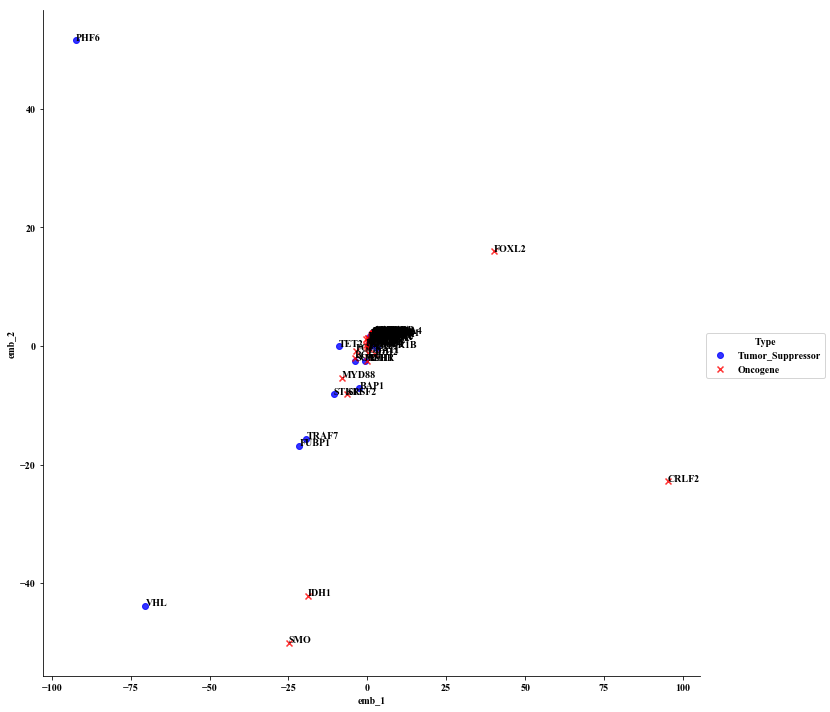

In [10]:

fig = plt.figure(figsize=(20, 10))
snsplot = sns.lmplot(data=X_df, x='emb_1', y='emb_2', hue='Type', fit_reg=False, size=10, x_jitter=0.001, y_jitter=0.001, markers=['o', 'x'],
           palette=dict(Tumor_Suppressor="b", Oncogene="r")
          )
#plt.xlim([-2, 3])
#plt.ylim([-3, 3])

for name, col in X_df.iterrows():
    plt.text(x=col.emb_1+.05, y=col.emb_2+.05, s=name)
    
snsplot.savefig(os.path.join(model_dir, 'embedding_{}.png'.format(type_of_emb)), dpi=300)

## Clustering

In [11]:
from sklearn.cluster import KMeans
cols = [col for col in X_df.columns if not type(col) is str]
pred = KMeans(n_clusters=5).fit_predict(X_df[cols], y)

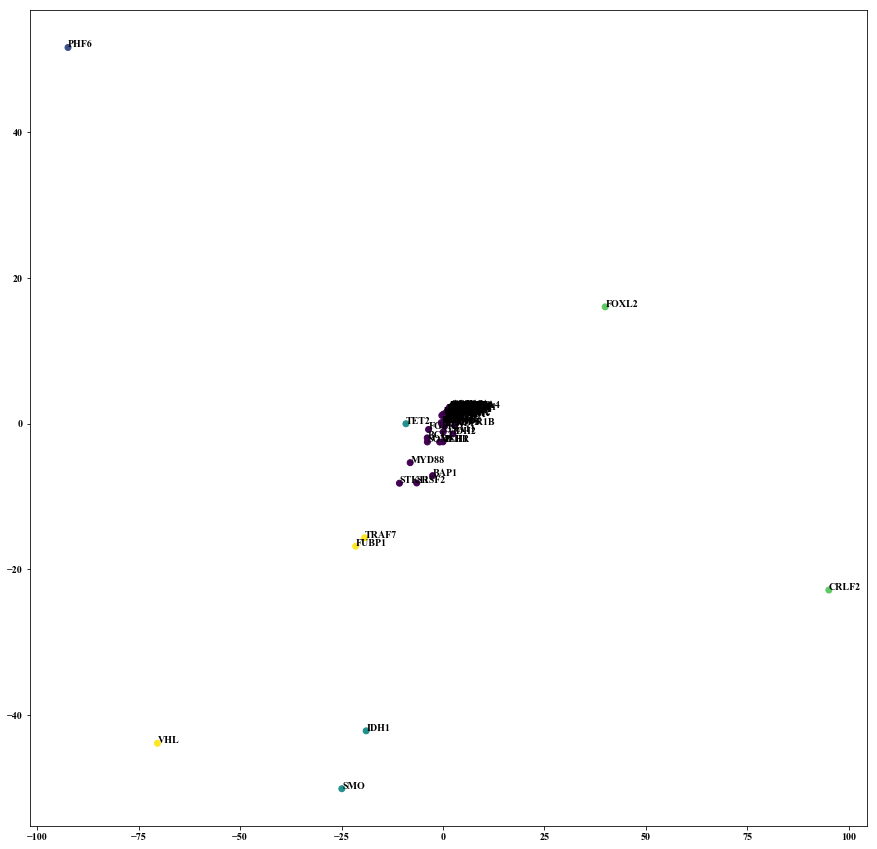

In [12]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(x=X_df.emb_1, y=X_df.emb_2, c=pred)
#plt.xlim([-2, 3])
#plt.ylim([-3, 3])

for name, col in X_df.iterrows():
    plt.text(x=col.emb_1+.05, y=col.emb_2+.05, s=name)

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = linkage(X_df[cols], 'ward')
c, coph_dists = cophenet(Z, pdist(X_df[cols]))
c

0.9822443148304453

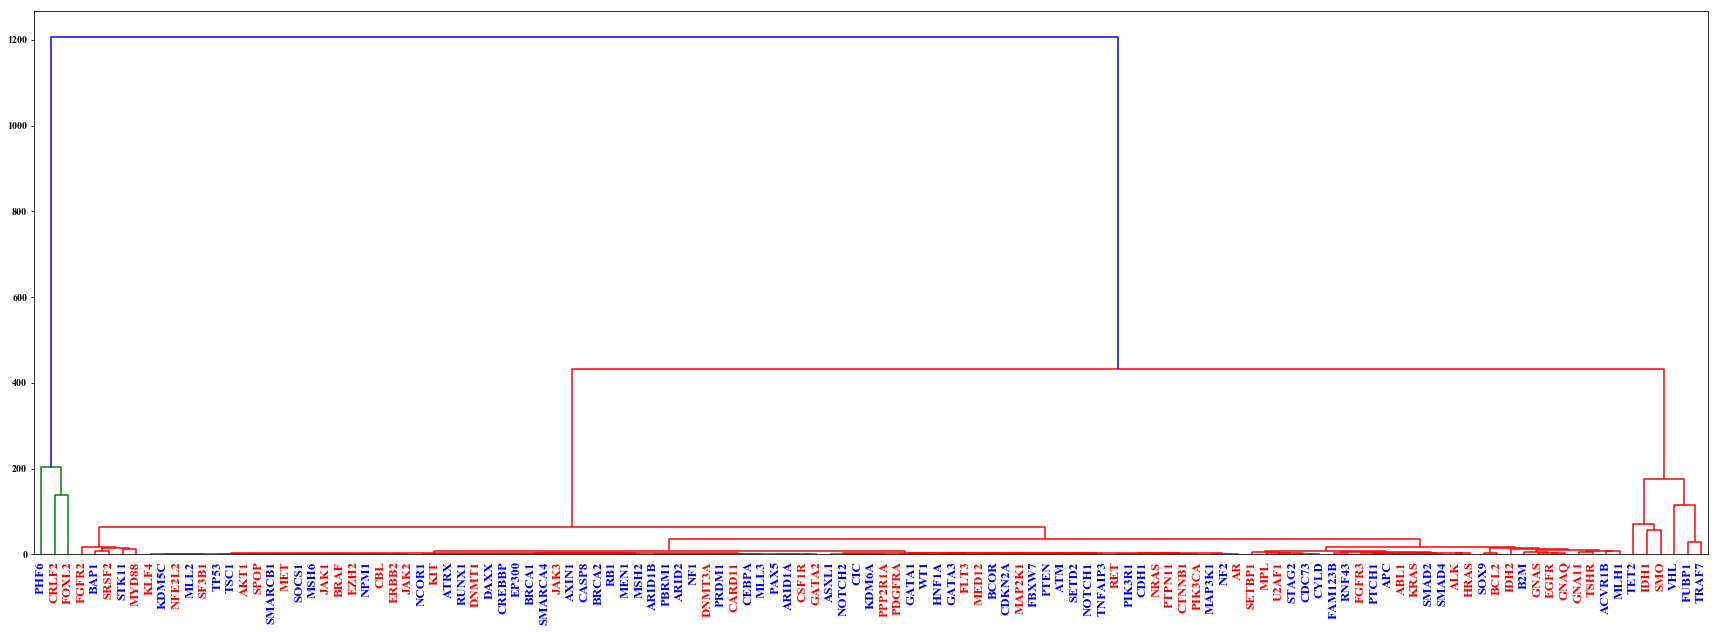

In [22]:
fig = plt.figure(figsize=(30, 10))
_ = dendrogram(Z, leaf_rotation=90, labels=X_df.index, leaf_font_size=13)

# color the leaves according to whether they are oncogenes or TSGs
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    onco = oncogenes['Gene Symbol'].str.contains(lbl.get_text().strip()).any()
    lbl.set_color('red' if onco else 'blue')

fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes.svg'))
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes.png'), dpi=300)

In [15]:
cancers = pd.concat((suppressors, oncogenes))

In [16]:
preds = pd.read_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'), sep='\t')
preds[preds.Name.isin(cancers['Gene Symbol'])]

,ID,label,Name,Prob_pos_1,Prob_pos_2,Prob_pos_3,Prob_pos_4,Prob_pos_5,Prob_pos_6,Prob_pos_7,Prob_pos_8,Prob_pos_9,Prob_pos_10,Num_Pos,Mean_Pred,Std_Pred
0,ENSG00000141510,True,TP53,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
2,ENSG00000100393,True,EP300,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
4,ENSG00000005339,True,CREBBP,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
6,ENSG00000175387,True,SMAD2,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
11,ENSG00000168036,True,CTNNB1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
14,ENSG00000145675,True,PIK3R1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
19,ENSG00000169083,True,AR,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
20,ENSG00000142208,True,AKT1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
22,ENSG00000139687,True,RB1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
25,ENSG00000012048,True,BRCA1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000


## Check if the Input Features are Clustering

In [17]:
inp_sup = features[nodes.Name.isin(suppressors['Gene Symbol'])]
inp_onc = features[nodes.Name.isin(oncogenes['Gene Symbol'])]

In [18]:
X_inp = np.concatenate((inp_sup, inp_onc))
y = np.concatenate((np.zeros(inp_sup.shape[0]), np.ones(inp_onc.shape[0])))

In [19]:
if type_of_emb is 'TSNE':
    dim_red = PCA(n_components=n_comp)
else:
    dim_red = TSNE(n_components=n_comp)
emb = dim_red.fit_transform(X_inp)
names = pd.concat((suppressors['Gene Symbol'], oncogenes['Gene Symbol']))

(123, 3) (123,)


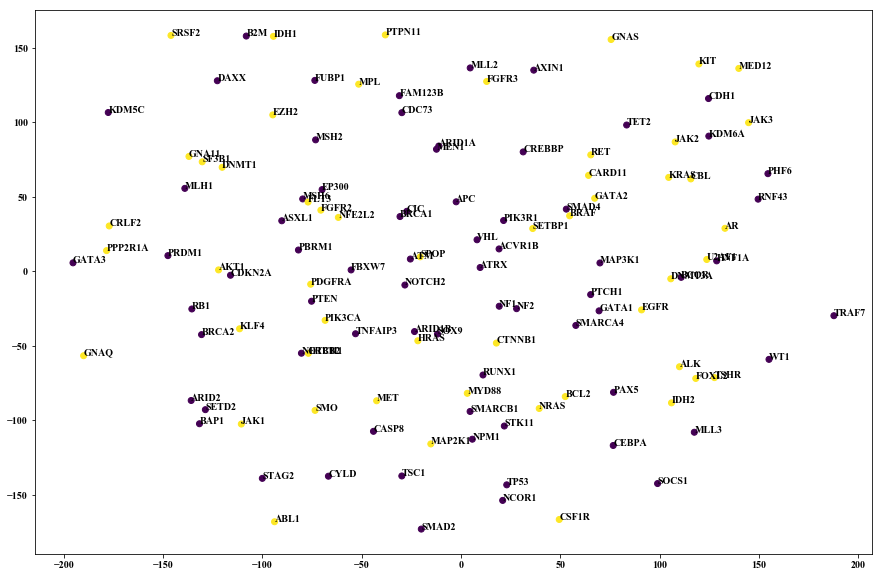

In [20]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(x=emb[:, 0], y=emb[:, 1], c=y)
print (emb.shape, names.shape)
for i in range(len(names)):
    plt.text(x=emb[i, 0]+.05, y=emb[i, 1]+.05, s=names.iloc[i])

0.6746278392418169


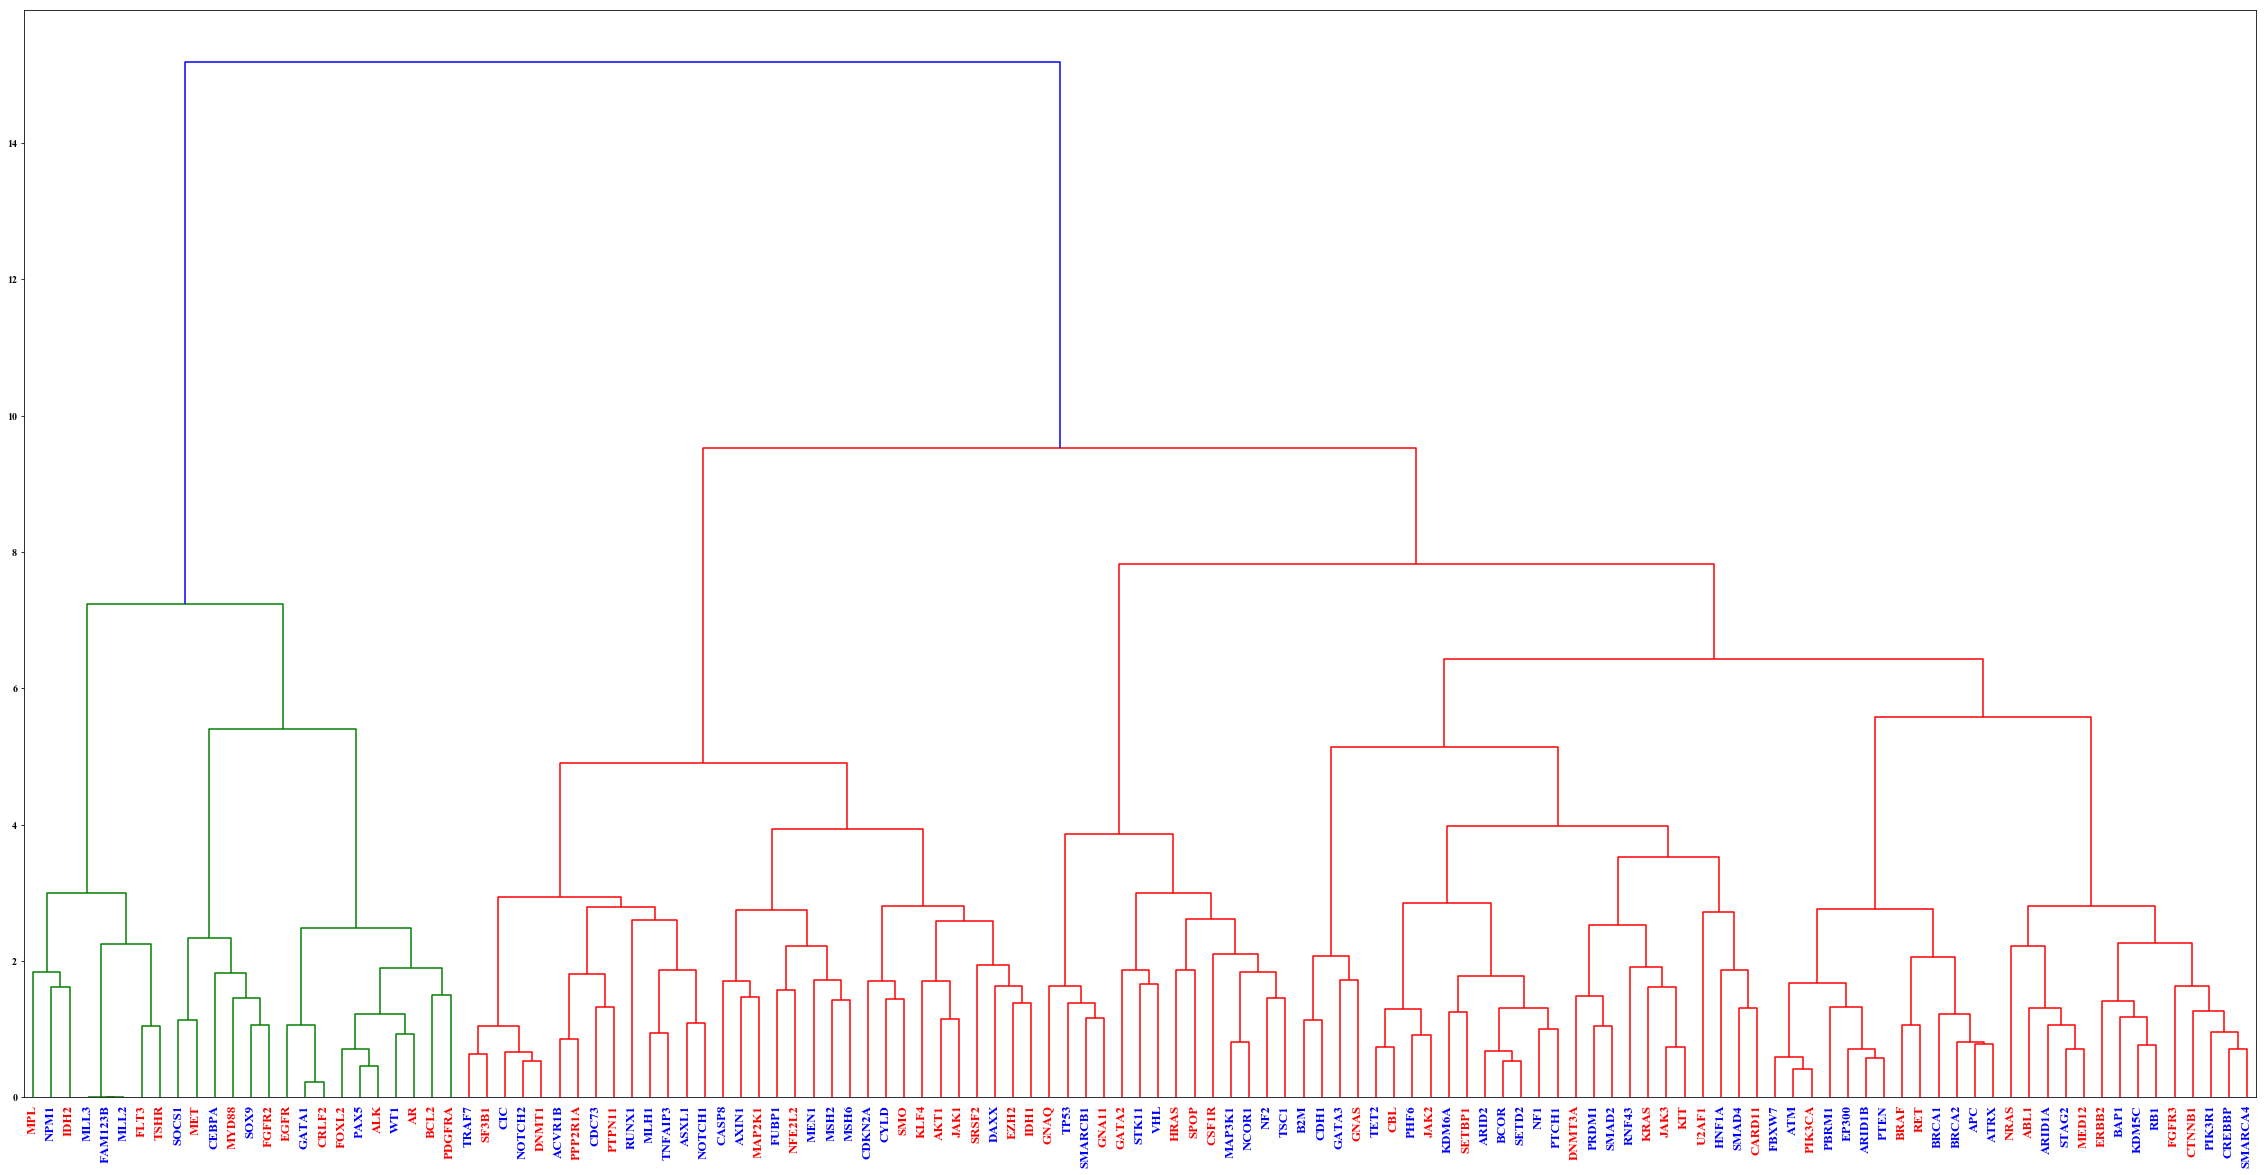

In [21]:
Z_inp = linkage(X_inp, 'ward')
c, coph_dists = cophenet(Z_inp, pdist(X_inp))
print (c)
fig = plt.figure(figsize=(40, 20))
_ = dendrogram(Z_inp, leaf_rotation=90, labels=np.array(names), leaf_font_size=13)

# color the leaves according to whether they are oncogenes or TSGs
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    onco = oncogenes['Gene Symbol'].str.contains(lbl.get_text().strip()).any()
    #print (onco)
    lbl.set_color('red' if onco else 'blue')
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes_input.svg'))
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes_input.png'), dpi=300)

## Check if suppressors are more methylated than oncogenes

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 'type']


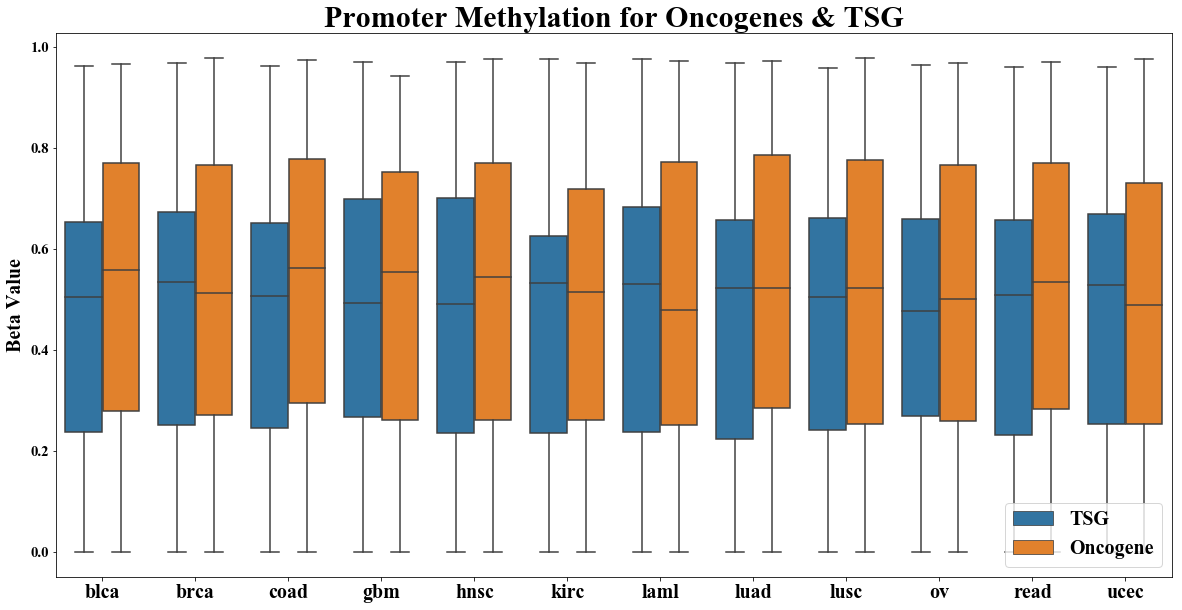

In [108]:
# build feature dataframe
feat_df = pd.DataFrame(X_inp, index=names)
feat_df['type'] = np.array(['TSG']*X_sup.shape[0] + ['Oncogene']*X_onc.shape[0])

# select only promoter methylation
meth_cols = [i for i in range(11, 23)] + ['type']
print (meth_cols)
meth_df = feat_df[meth_cols]
gn = ['TP53', 'SF3B1', 'CASP8', 'CDH1', 'JAK1']
#meth_df = meth_df[meth_df.index.isin(gn)]
meth_df.columns = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec', 'type']

# plot
fig = plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=pd.melt(meth_df, id_vars=['type']), x='variable', y='value', hue='type')
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='lower right', fontsize=20)

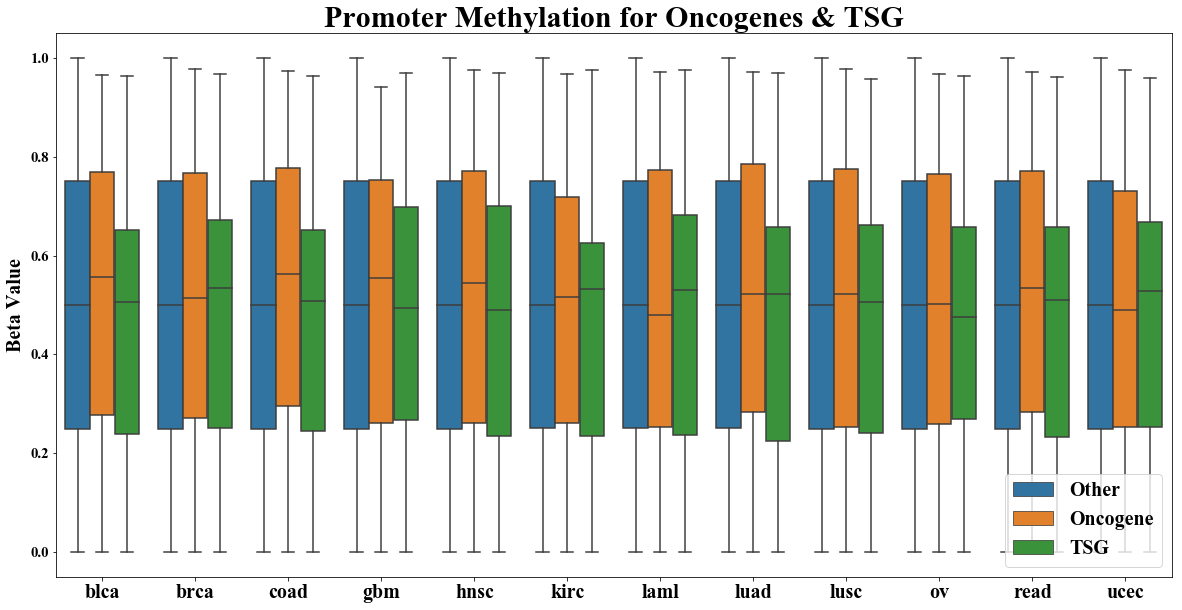

In [124]:
# build dataframe for all features with type
all_feat = pd.DataFrame(features, index=node_names[:, 1])
all_feat['type'] = 'Other'
all_feat.loc[all_feat.index.isin(suppressors['Gene Symbol']), 'type'] = 'TSG'
all_feat.loc[all_feat.index.isin(oncogenes['Gene Symbol']), 'type'] = 'Oncogene'
all_meth = all_feat[meth_cols]
all_meth.columns = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec', 'type']

# plot
fig = plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=pd.melt(all_meth, id_vars=['type']), x='variable', y='value', hue='type')
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='lower right', fontsize=20)

fig.savefig(os.path.join(model_dir, 'methprom_boxplot_onco_vs_tsg_vs_rest.png'), dpi=300)

In [127]:
all_meth.type.value_counts()

Other       12006
TSG            71
Oncogene       52
Name: type, dtype: int64